In [1]:
### Prepare the package and data we need, for this part I use Yimeng's data since it contains labels directly
import pandas as pd
import xgboost as xgb

path = '../../data/initial_data.csv'
df = pd.read_csv(path, header=0, index_col=False)
df.head()

,domain,domain_type
0,wisuolycossttqrj.com,dga
1,wi-wamss.org,benign
2,qcxfurnkbqidxxcl.biz,dga
3,192-168-1-1-admin.ru,benign
4,dblsiobnkjxomkmh.ru,dga


In [4]:
### You can diy this part yourself since I am just write examples
def generate_feature(df):
    # I use the length of domain name as a feature
    df['feature'] = df['domain'].apply(lambda x :len(x))
    return df
df = generate_feature(df)
df.head()

,domain,domain_type,feature
0,wisuolycossttqrj.com,dga,20
1,wi-wamss.org,benign,12
2,qcxfurnkbqidxxcl.biz,dga,20
3,192-168-1-1-admin.ru,benign,20
4,dblsiobnkjxomkmh.ru,dga,19


In [5]:
### Normally machine learning model can not handle text data, so we need to transform our label to [0,1]
def data_transformation(df):
    df['domain_type'] = df['domain_type'].apply(lambda x: 1 if x == 'benign' else 0)
    return df
df = data_transformation(df)
df.head()

,domain,domain_type,feature
0,wisuolycossttqrj.com,0,20
1,wi-wamss.org,1,12
2,qcxfurnkbqidxxcl.biz,0,20
3,192-168-1-1-admin.ru,1,20
4,dblsiobnkjxomkmh.ru,0,19


In [6]:
### create our train and test data, the feature set will not include the original_domain
X = df['feature']
y = df['domain_type']

In [18]:
### The random_state is a parameter controling the randomness of train and test splitting, ignore it
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [21]:
### train our model, this part is similar to what models in sklearn do, there are other ways they provided but I choose the way you are familar
import numpy as np
X_train = np.reshape(X_train,(-1,1))
X_test = np.reshape(X_test,(-1,1))
xgbmodel = xgb.XGBClassifier().fit(X_train, y_train)
predictions = xgbmodel.predict(X_test)

In [23]:
### inspect the result(Actually is very good since the dga domains are much longer than benign ones)
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, predictions, average=None)

(array([0.92582418, 1.        ]),
 array([1.        , 0.91809909]),
 array([0.96148359, 0.957301  ]),
 array([2022, 1978], dtype=int64))

#*Another way to fit Xgboost model, this way may be more flexible*

In [24]:
# construct dataset (2-D numpy type)
dtrain = xgb.DMatrix(X_train, label=y_train)

In [25]:
# setting parameters
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [26]:
# training our model and inspect each round performance
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.95905	train-auc:0.95494
[1]	eval-auc:0.95905	train-auc:0.95494
[2]	eval-auc:0.96308	train-auc:0.96182
[3]	eval-auc:0.96899	train-auc:0.96686
[4]	eval-auc:0.96899	train-auc:0.96686
[5]	eval-auc:0.96899	train-auc:0.96686
[6]	eval-auc:0.96899	train-auc:0.96686
[7]	eval-auc:0.96899	train-auc:0.96686
[8]	eval-auc:0.96899	train-auc:0.96686
[9]	eval-auc:0.96899	train-auc:0.96686


In [27]:
# construct test data, for test,we do not need labels
dtest = xgb.DMatrix(X_test)

In [28]:
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

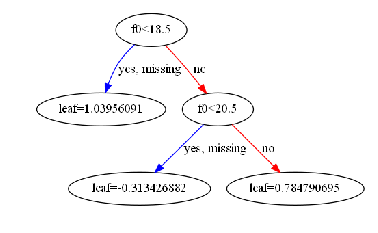

In [32]:
# visualize our tree
xgb.plot_tree(bst, num_trees=2)

[Xgboost documentation](https://xgboost.readthedocs.io/en/latest/python/index.html)